# Biodiversity Project

#### Introduction
On this project, we're going to do some exploratory data analysis and statistical analysis about species at various national parks.

The data that we'll be working with for this project is *inspired* by real data, but is mostly fictional.

#### Par 1: Exploratory Data Analysis

In [32]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency


Let's load the dataset about different species in the National Parks and inspect it:

In [33]:
species = pd.read_csv('species_info.csv')


In [34]:
print(species.head())


  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  


Now let's learning a bit more about our data by answer each of the following questions.

In [35]:
num_species = len(species)
print(num_species)

5824


What are the different values of `category` in `species`?

In [36]:
categ_num = species.category.nunique()
print ("There are " + str(categ_num) + "different categories")
print("          ")
categ_values = species['category'].value_counts()

print(categ_values)

There are 7different categories
          
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: category, dtype: int64


What are the different values of `conservation_status`?

In [37]:
#conserv_categ = species['conservation_status'].value_counts()
conserv_categ = species['conservation_status'].unique()
print('The values of conservation status are: ' + str(conserv_categ))

The values of conservation status are: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']



The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range

We'd like to count up how many species meet each of these criteria.

In [38]:
status_count = species.groupby('conservation_status').scientific_name.count().reset_index()
print(status_count)

  conservation_status  scientific_name
0          Endangered               16
1         In Recovery                4
2  Species of Concern              161
3          Threatened               10


As we saw before, there are far more than 200 species in the `species` table.  Clearly, only a small number of them are categorized as needing some sort of protection.  The rest have `conservation_status` equal to `None`.  Because `groupby` does not include `None`, we will need to fill in the null values. 

In [39]:
species.fillna('No Intervention', inplace=True)


Now let's see how many species require `No Intervention`.

In [40]:
status_count = species.groupby('conservation_status').scientific_name.count().reset_index()
print(status_count)

  conservation_status  scientific_name
0          Endangered               16
1         In Recovery                4
2     No Intervention             5633
3  Species of Concern              161
4          Threatened               10


In the next step we'll create a bar chart but first, let's sort the columns by how many species are in each categories.

In [41]:
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

print(protection_counts.head())

  conservation_status  scientific_name
1         In Recovery                4
4          Threatened               10
0          Endangered               15
3  Species of Concern              151
2     No Intervention             5363


Now let's create a bar chart to show conservation status by species.

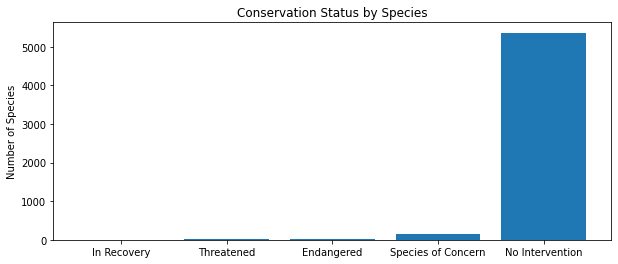

In [42]:
plt.figure(figsize=(10, 4))
ax = plt.subplot()
plt.bar(range(len(protection_counts)),
        protection_counts.scientific_name.values)
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status.values)
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
plt.show()


Are certain types of species more likely to be endangered?

In [43]:
#species['is_protected'] = species.conservation_status.apply(lambda x: 
   #                                                         True if species.conservation_status != 'No Intervention' 
    #                                                        else False)

species['is_protected'] = species.conservation_status != 'No Intervention'

In [44]:
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index()


In [45]:
print(category_counts.head())

    category  is_protected  scientific_name
0  Amphibian         False               72
1  Amphibian          True                7
2       Bird         False              413
3       Bird          True               75
4       Fish         False              115


It's going to be easier to view this data if we pivot it.  

In [46]:
category_pivot = category_counts.pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                                .reset_index()

In [47]:
print(category_pivot)

is_protected           category  False  True
0                     Amphibian     72     7
1                          Bird    413    75
2                          Fish    115    11
3                        Mammal    146    30
4             Nonvascular Plant    328     5
5                       Reptile     73     5
6                Vascular Plant   4216    46


In [48]:
category_pivot.columns = ['category', 'not_protected', 'protected']

Let's create a new column of `category_pivot` called `percent_protected`.

In [49]:
category_pivot['percent_protcted'] = category_pivot.protected/(category_pivot.protected+category_pivot.not_protected) * 100

In [50]:
print(category_pivot)

            category  not_protected  protected  percent_protcted
0          Amphibian             72          7          8.860759
1               Bird            413         75         15.368852
2               Fish            115         11          8.730159
3             Mammal            146         30         17.045455
4  Nonvascular Plant            328          5          1.501502
5            Reptile             73          5          6.410256
6     Vascular Plant           4216         46          1.079305


#### Part 2: Statistical Analysis

It looks like species in category `Mammal` are more likely to be endangered than species in `Bird`.  We're going to do a significance test, a Chi Square test to see if this statement is true. 

In [51]:
from scipy.stats import chi2_contingency
contingency = [[30, 146], [75, 413]]

In [52]:
chi2_contingency(contingency)

(0.1617014831654557,
 0.6875948096661336,
 1,
 array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

The p-value is 0.69 so this difference isn't significant!

Let's test the difference between `Reptile` and `Mammal`.

In [53]:
cont = [[5, 73], [30,146]]
chi2_contingency(cont)

(4.289183096203645,
 0.03835559022969898,
 1,
 array([[ 10.7480315,  67.2519685],
        [ 24.2519685, 151.7480315]]))

The p-value is 0.03 so there is a significant difference between `Reptile` and `Mammal`!

For the next step we will need the file observations which includes sightings of different species at several national parks for the past 7 days

In [54]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


There have been some studies of the number of sheep sightings at different national parks.  There are several different scientific names for different types of sheep.  We'd like to know which rows of `species` are referring to sheep.

In [55]:
species['is_sheep'] = species.common_names.apply(lambda x: True if 'Sheep' in x 
                                                else False)
species.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False


Let's select the rows of `species` where `is_sheep` is `True` and examine the results.

In [56]:
species[species.is_sheep]

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
1139,Vascular Plant,Rumex acetosella,"Sheep Sorrel, Sheep Sorrell",No Intervention,False,True
2233,Vascular Plant,Festuca filiformis,Fineleaf Sheep Fescue,No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3758,Vascular Plant,Rumex acetosella,"Common Sheep Sorrel, Field Sorrel, Red Sorrel,...",No Intervention,False,True
3761,Vascular Plant,Rumex paucifolius,"Alpine Sheep Sorrel, Fewleaved Dock, Meadow Dock",No Intervention,False,True
4091,Vascular Plant,Carex illota,"Sheep Sedge, Smallhead Sedge",No Intervention,False,True
4383,Vascular Plant,Potentilla ovina var. ovina,Sheep Cinquefoil,No Intervention,False,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


In [57]:
sheep_species = species[(species.is_sheep == True) & (species.category == 'Mammal')]
sheep_species.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


In [58]:
sheep_observations = sheep_species.merge(observations)
sheep_observations.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep,park_name,observations
0,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True,Yosemite National Park,126
1,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True,Great Smoky Mountains National Park,76
2,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True,Bryce National Park,119
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True,Yellowstone National Park,221
4,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True,Yellowstone National Park,219


In [59]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum().reset_index()
obs_by_park

,park_name,observations
0,Bryce National Park,250
1,Great Smoky Mountains National Park,149
2,Yellowstone National Park,507
3,Yosemite National Park,282


We are going to create a bar chart to show the different number of observations per week at each park.

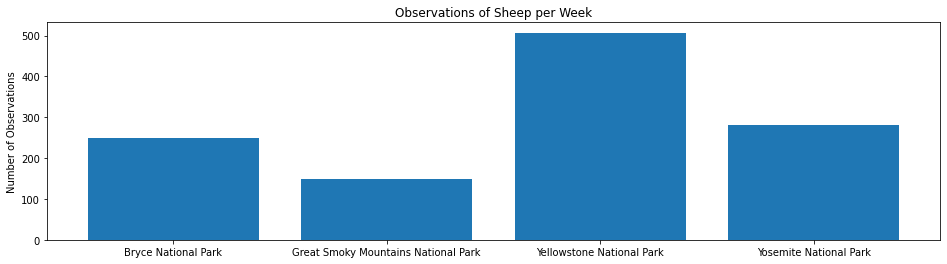

In [60]:
plt.figure(figsize=(16,4))
ax=plt.subplot()
plt.bar(range(len(obs_by_park)), obs_by_park.observations.values)
ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park.park_name.values)
plt.ylabel('Number of Observations')
plt.title('Observations of Sheep per Week')
plt.show()




Our scientists know that 15% of sheep at Bryce National Park have foot and mouth disease.  Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park.  The scientists want to test whether or not this program is working.  They want to be able to detect reductions of at least 5 percentage points.
Therefore we need to calculate the number of sheep that they would need to observe from each park with the level of significance (90%).


In [28]:
minimum_detectable_effect = 100 * 0.05 / 0.15
minimum_detectable_effect


33.333333333333336

In [30]:
baseline = 15
sample_size_per_variant = 870

The number of sample needed to be observed would be 870 sheeps. 